# Welcome!
Today, we'll be using qBraid to understand how to embed classical images into quantum registers, the current embedding implementations, and the current limitations and problems at hand. 

## Getting Started on qBraid

### Step 1.
If you haven't already done so, please make a qBraid account and add the access code `EHNU6626` on the account.qbraid.com/account-details page. 


### Step 2.
Then click on the `Launch on qBraid` button in the README.md of this repository. The button will automatically clone the repository and take you to your *new* qBraid Lab integrated development environment. 

### Step 3.
Finally, install the qBraid-SDK environment via the qBraid Lab Environment Manager. On Lab you should see the `ENVS` icon on the right. The qBraid Lab Environment Manager is a robust package and virtual environment management system provided to qBraid end-users through a simple, intuitive graphical user interface. To expand the Environment Manager sidebar, click on Envs in the upper-right of the Lab console. My Environments are your currently installed environments. The qBraid Default environment and Microsoft Q# environment are installed by default.

Install environment
1. In the Environment Manager sidebar, click Add to view the environments available to install.

Choose the qBraid SDK, expand its panel, and click Install.

<img src="./_images/env_install.png">

3. Once the installation has started, the pannel is moved to the My Environments tab. Click Browse Environments to return to the My Environments tab and view its progress.



Browse Environments to return to the My Environments tab and view its progress.

<img src="./_images/env_installing.png">

4. When the installation is complete, the environment panel’s action button will switch from Installing… to Activate. Clicking Activate creates a new ipykernel, see Kernels for more.

<img src="./_images/kernel_activate.png">

To uninstall the environment, click on More, and then Uninstall. Learn more about qBraid Lab Environment Manager [here](https://qbraid-qbraid.readthedocs-hosted.com/en/stable/lab/environments.html#)

## Activate the qBraid SDK kernel
Under My Environments, choose the environment, and expand its pannel. Click Activate to activate the environment and create an associated ipykernel.

<img src="./_images/kernel_activate.png">

Switch notebook kernel
In the Launcher tab, under Notebooks, clicking on an ipykernel associated with an activated environment will automatically launch a Jupyter notebook (.ipynb file) using that kernel. In the upper-right of the newly created notebook, you can see which kernel is in use.

<img src="./_images/kernel_nb.png">

Clicking on the name of the current kernel, as circled above, will open the kernel selector, and allow you switch to any other active kernel.

<img src="./_images/kernel_switch.png">


Next we'll install tensorflow:

In [21]:
%pip install tensorflow
%pip install tensorboard
%pip install scikit-plot


[notice] A new release of pip available: 22.2.2 -> 22.3.1
[notice] To update, run: python -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip available: 22.2.2 -> 22.3.1
[notice] To update, run: python -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 298.0/298.0 kB 6.3 MB/s eta 0:00:0000:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.8/30.8 MB 36.5 MB/s eta 0:00:0000:0100:01
  Using cached threadpoolctl-3.1.0-py3-none-any.whl (14 kB)

[notice] A new release of pip available: 22.2.2 -> 22.3.1
[notice] To update, run: python -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [4]:
import os

import datetime
import matplotlib.pyplot as plt
import numpy as np
import pennylane as qml
# import qbraid
from scikitplot.metrics import plot_confusion_matrix
import tensorflow as tf


%matplotlib inline
# CONSTANTS
NUM_EXAMPLES=500
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

2022-11-25 22:45:23.776886: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-25 22:45:24.515676: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-11-25 22:45:24.515718: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-11-25 22:45:34.083510: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directo

# MNIST
The MNIST (Modified National Institute of Standards and Technology) database contains 70,000 28 x 28 images of handwritten digits from 0-9 and is seminal to machine learning. The MNIST handwritten dataset is the “Hello World” implementation for machine learning, and the dataset is used as a worldwide machine learning benchmark. 


## Starting off with a classical implementation
We will first load the data and apply a classical CNN (Convolutional Neural Network) to understand the mechanics of image classification.

### Loading the data
We load the data from tensorflow, a machine learning package developed by Google.

In [5]:
# Normalize the images from [0,255] to the [0.0,1.0] range.
x_train, x_test = x_train[..., np.newaxis]/255.0, x_test[..., np.newaxis]/255.0

print("Number of original training examples:", len(x_train))
print("Number of original test examples:", len(x_test))

Number of original training examples: 60000
Number of original test examples: 10000


In [6]:
y_train_onehot = tf.one_hot(y_train,10)
y_test_onehot = tf.one_hot(y_test,10)

2022-11-25 22:46:01.304988: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-11-25 22:46:01.305021: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2022-11-25 22:46:01.305053: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (jupyter-rickyyoung-40qbraid-2ecom): /proc/driver/nvidia/version does not exist
2022-11-25 22:46:01.305354: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Let's plot the images

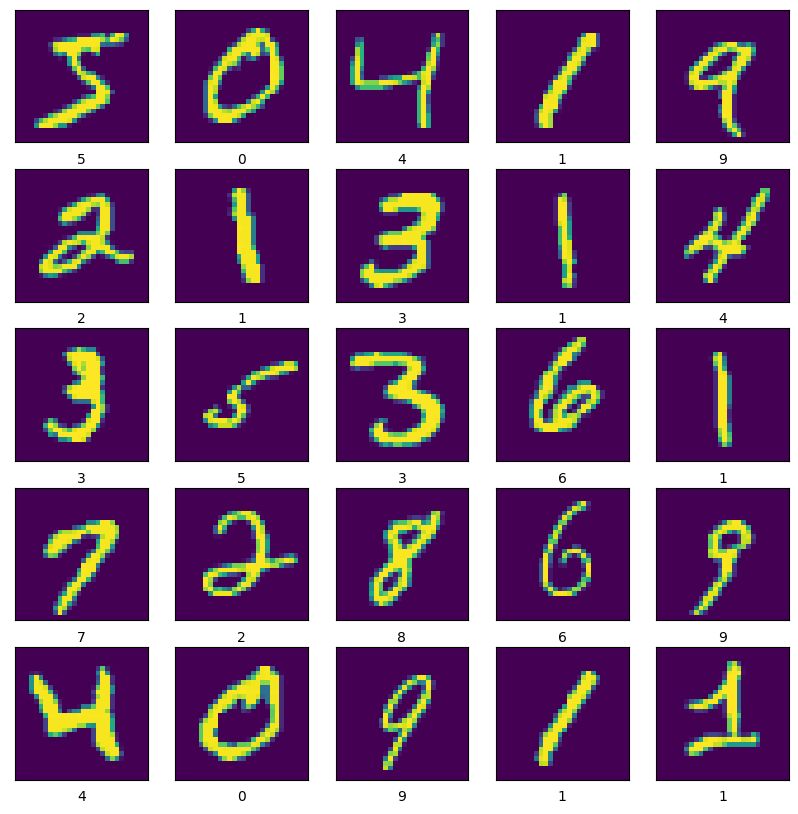

In [5]:
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(x_train[i])
    plt.xlabel(y_train[i])
plt.show()

### Run a CNN (convolutional neural network)
To better understand image classification, we will first approach the problem classically. We will run a simple CNN which has 2 convolutional layers and will classify, on average, to 98%. Briefly, a convolution layer is an integral transform which detects certain features using a filter to pass over the image.
<img src="./_images/convolutionalfilter.gif">

In [12]:
# Tensorboard callback
%load_ext tensorboard

# Specify Folders
current_time = str(datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
train_log_dir = 'logs/tensorboard/' + current_time
test_log_dir = 'logs/tensorboard/test/' + current_time
path_for_checkpoint_callback = 'logs/summary/'+current_time

# Create callback
tensorboard_callback = tf.keras.callbacks.TensorBoard(
                log_dir=train_log_dir, histogram_freq=1, profile_batch=3
            )

# Model Checkpoint callback
model_ckpt =  tf.keras.callbacks.ModelCheckpoint(
                path_for_checkpoint_callback, save_weights_only=True
            )

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


2022-11-25 17:26:26.144302: I tensorflow/core/profiler/lib/profiler_session.cc:101] Profiler session initializing.
2022-11-25 17:26:26.144340: I tensorflow/core/profiler/lib/profiler_session.cc:116] Profiler session started.
2022-11-25 17:26:26.145664: I tensorflow/core/profiler/lib/profiler_session.cc:128] Profiler session tear down.


In [13]:
def create_classical_model():
    # A simple model based off LeNet from https://keras.io/examples/mnist_cnn/
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Conv2D(32, [3, 3], activation='relu', input_shape=(28,28,1)))
    model.add(tf.keras.layers.Conv2D(64, [3, 3], activation='relu'))
    model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
    model.add(tf.keras.layers.Dropout(0.25))
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(128, activation='relu'))
    model.add(tf.keras.layers.Dropout(0.5))
    model.add(tf.keras.layers.Dense(10, activation='softmax'))
    return model


model = create_classical_model()
model.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
              optimizer=tf.keras.optimizers.Adam(0.002),
               metrics=[tf.keras.metrics.CategoricalAccuracy()])

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 26, 26, 32)        320       
                                                                 
 conv2d_5 (Conv2D)           (None, 24, 24, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 12, 12, 64)       0         
 2D)                                                             
                                                                 
 dropout_4 (Dropout)         (None, 12, 12, 64)        0         
                                                                 
 flatten_2 (Flatten)         (None, 9216)              0         
                                                                 
 dense_4 (Dense)             (None, 128)               1179776   
                                                      

In [14]:
model.fit(x_train,
          y_train_onehot,
          batch_size=128,
          epochs=10,
          verbose=1,
          validation_data=(x_test[:1000], y_test_onehot[:1000]),
          callbacks=[tensorboard_callback,model_ckpt])

cnn_results = model.evaluate(x_test, y_test_onehot)

Epoch 1/10
  2/469 [..............................] - ETA: 1:16 - loss: 2.2177 - categorical_accuracy: 0.2031

2022-11-25 17:26:28.394350: I tensorflow/core/profiler/lib/profiler_session.cc:101] Profiler session initializing.
2022-11-25 17:26:28.394389: I tensorflow/core/profiler/lib/profiler_session.cc:116] Profiler session started.
2022-11-25 17:26:28.560085: I tensorflow/core/profiler/lib/profiler_session.cc:67] Profiler session collecting data.
2022-11-25 17:26:28.561024: I tensorflow/core/profiler/lib/profiler_session.cc:128] Profiler session tear down.
2022-11-25 17:26:28.590806: I tensorflow/core/profiler/rpc/client/save_profile.cc:164] Collecting XSpace to repository: logs/tensorboard/20221125-172626/plugins/profile/2022_11_25_17_26_28/jupyter-rickyyoung-40qbraid-2ecom.xplane.pb


469/469 [==============================] - ETA: 0s - loss: 0.1932 - categorical_accuracy: 0.9410

2022-11-25 17:27:40.569516: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 283115520 exceeds 10% of free system memory.


469/469 [==============================] - 74s 155ms/step - loss: 0.1932 - categorical_accuracy: 0.9410 - val_loss: 0.0446 - val_categorical_accuracy: 0.9870
Epoch 2/10
469/469 [==============================] - ETA: 0s - loss: 0.0760 - categorical_accuracy: 0.9769

2022-11-25 17:28:52.006420: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 283115520 exceeds 10% of free system memory.


469/469 [==============================] - 71s 152ms/step - loss: 0.0760 - categorical_accuracy: 0.9769 - val_loss: 0.0423 - val_categorical_accuracy: 0.9800
Epoch 3/10
469/469 [==============================] - ETA: 0s - loss: 0.0584 - categorical_accuracy: 0.9823

2022-11-25 17:30:02.897594: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 283115520 exceeds 10% of free system memory.


469/469 [==============================] - 71s 151ms/step - loss: 0.0584 - categorical_accuracy: 0.9823 - val_loss: 0.0271 - val_categorical_accuracy: 0.9900
Epoch 4/10
469/469 [==============================] - ETA: 0s - loss: 0.0485 - categorical_accuracy: 0.9852

2022-11-25 17:31:13.150430: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 283115520 exceeds 10% of free system memory.


469/469 [==============================] - 70s 150ms/step - loss: 0.0485 - categorical_accuracy: 0.9852 - val_loss: 0.0355 - val_categorical_accuracy: 0.9880
Epoch 5/10
469/469 [==============================] - ETA: 0s - loss: 0.0389 - categorical_accuracy: 0.9877

2022-11-25 17:32:25.228069: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 283115520 exceeds 10% of free system memory.


469/469 [==============================] - 72s 154ms/step - loss: 0.0389 - categorical_accuracy: 0.9877 - val_loss: 0.0325 - val_categorical_accuracy: 0.9890
Epoch 6/10
469/469 [==============================] - 70s 150ms/step - loss: 0.0373 - categorical_accuracy: 0.9880 - val_loss: 0.0254 - val_categorical_accuracy: 0.9930
Epoch 7/10
469/469 [==============================] - 71s 151ms/step - loss: 0.0318 - categorical_accuracy: 0.9897 - val_loss: 0.0216 - val_categorical_accuracy: 0.9900
Epoch 8/10
469/469 [==============================] - 70s 150ms/step - loss: 0.0275 - categorical_accuracy: 0.9910 - val_loss: 0.0163 - val_categorical_accuracy: 0.9950
Epoch 9/10
469/469 [==============================] - 71s 151ms/step - loss: 0.0280 - categorical_accuracy: 0.9913 - val_loss: 0.0158 - val_categorical_accuracy: 0.9930
Epoch 10/10
313/313 [==============================] - 4s 11ms/step - loss: 0.0338 - categorical_accuracy: 0.9911


### Analysis of classical layers using Tensorboard
We will use tensorboard to analyze the results

In [29]:
%tensorboard --logdir logs

ERROR: Could not find `tensorboard`. Please ensure that your PATH
contains an executable `tensorboard` program, or explicitly specify
the path to a TensorBoard binary by setting the `TENSORBOARD_BINARY`
environment variable.

In [17]:
y_pred = model.predict(x_test)
y_pred = np.argmax(y_pred, axis=1)
print(y_pred, y_test)

313/313 [==============================] - 3s 8ms/step
[7 2 1 ... 4 5 6] [7 2 1 ... 4 5 6]


<AxesSubplot:title={'center':'Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

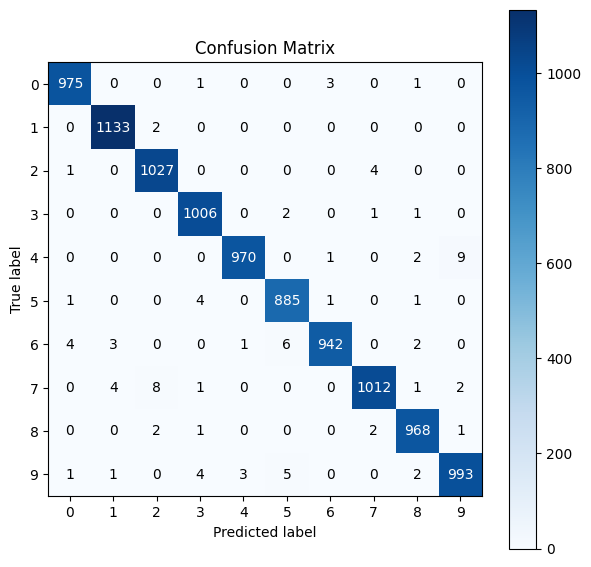

In [30]:
fig, ax = plt.subplots(figsize=(7,7))
plot_confusion_matrix(y_test, y_pred, ax=ax)

What we see here is that the model can properly classify images incredibly well with a classical CNN. Let's see how we can do the same using quantum computing.

## Quantum Computing and it's proposed benefits and limitations
Using a quantum computer for machine learning and 

### Current challenge: embedding the circuit
During the NISQ era, there are severe limitations with how to encoding the images onto a quantum register for gate based implementations. For MNIST, the full image cannot be encoded into a quantum register; therefore, downsampling techniques are used to reduce the image size.

- How many qubits are needed



## Apply a standardize preprocessing
For this demo, we will only apply one classical preprocessing technique and different embedding techniques. This is a non-standard process since embedding techniques can vary in # of qubits,

Further we will keep the quantum layers to be the same for each of the embedding processes.

There is some empty space around the image so we will first remove it.

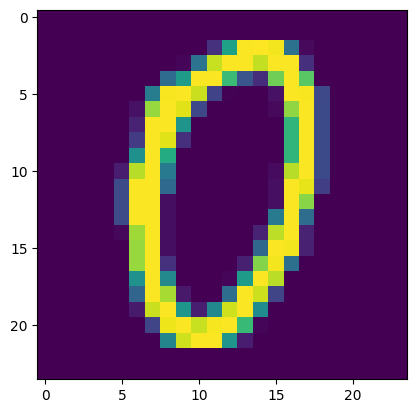

In [103]:
plt.imshow(x_train_crop[1000])


In [25]:
# Resize the images to fit on a quantum register

x_train_crop = np.array([x.reshape(28,28)[3:27,3:27] for x in x_train])
x_test_crop =np.array([x.reshape(28,28)[3:27,3:27] for x in x_test])

x_train_crop = np.expand_dims(x_train_crop, -1)
x_test_crop = np.expand_dims(x_test_crop, -1)

x_train_small_2562 = tf.image.resize(x_train_crop, [16,16]).numpy()
x_test_small_256 = tf.image.resize(x_test_crop, [16,16]).numpy()
print(len(x_train_small_256))

16


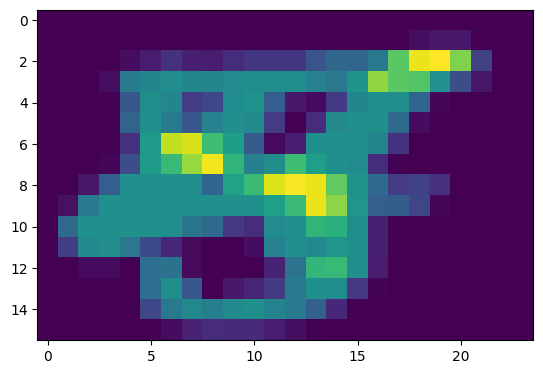

In [26]:
plt.imshow(x_train_small_256[10])

### Methods of embedding the image into a circuit

First we need to pre-process the data to ensure it can be embedded.

#### Basis Embedding
Basis embedding applies the 

#### Amplitude Embedding

#### Other Technique from a paper

### Other techniques (kernel methods etc).

### Running a model


#### Analysis of current implementations using Tensorboard and qBraid SDK

## Other methods, kernel methods